In [1]:
!curl --header "Host: storage.googleapis.com" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36 Edg/89.0.774.76" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/wandb_datasets/nature_12K.zip" -L -o "nature_12K.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3639M  100 3639M    0     0  56.2M      0  0:01:04  0:01:04 --:--:-- 79.1M


In [2]:
!unzip "/content/nature_12K.zip"

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [3]:
import shutil
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,Activation,Dropout,Flatten,BatchNormalization
from tensorflow.keras.models import Model,Sequential
import random 
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

In [4]:
class CNN:
  def __init__(self,no_of_filters=16,size_of_filters=(3,3),activation_func="relu",neurons_in_dense_layer=128
               ,dropout=0.3,batch_norm=False,doubling=False,augmentation=False):
    self.augmentation = augmentation
    self.dropout = dropout
    self.doubling = doubling
    self.batch_norm = batch_norm
    self.no_of_filters = no_of_filters
    self.size_of_filters = size_of_filters
    self.activation_func = activation_func
    self.neurons_in_dense_layer = neurons_in_dense_layer
    self.train_path = "/content/inaturalist_12K/train/"
    self.cv_path = "/content/inaturalist_12K/cv/"
    self.test_path = "/content/inaturalist_12K/val/"
    
  def generate_data(self):
    if self.augmentation:
      train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,horizontal_flip=True)
    else:
      train_datagen = ImageDataGenerator(rescale=1./255)
    cv_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    self.train_generator = train_datagen.flow_from_directory(self.train_path,target_size=(224,224),seed=10,batch_size=64,shuffle=True,class_mode="categorical",color_mode="rgb")
    self.cv_generator = cv_datagen.flow_from_directory(self.cv_path,target_size=(224,224),seed=10,batch_size=64,shuffle=True,class_mode="categorical",color_mode="rgb")
    self.test_generator = test_datagen.flow_from_directory(self.test_path,target_size=(224,224),seed=10,batch_size=64,shuffle=True,class_mode="categorical",color_mode="rgb")

  def create_cv_data(self):
    classes = sorted(os.listdir(self.train_path))[1:]
    os.mkdir(self.cv_path)
    for cls in classes:
      os.mkdir(self.cv_path+cls)

    for cls in classes:
      no_of_files = len(os.listdir(self.train_path+cls))
      files = os.listdir(self.train_path+cls)
      files = np.asarray(files)

      x = [i for i in range(no_of_files)]
      random.shuffle(x)
      index = x[:int(0.1*no_of_files)]
      file_names = files[index]

      for z in file_names:
        shutil.move(self.train_path+cls+"/"+z , self.cv_path+cls+"/"+z)

  def create_model(self):
    self.generate_data()
    model = Sequential()
    random.seed(10)
    for i in range(5):
      if i==0:
        model.add(Conv2D(self.no_of_filters, self.size_of_filters ,padding="same",activation= self.activation_func, input_shape=(224,224,3)))
      else:
        if self.doubling:
          model.add(Conv2D(self.no_of_filters*(2**i), self.size_of_filters ,padding="same",activation = self.activation_func))
        else:
          model.add(Conv2D(self.no_of_filters, self.size_of_filters ,padding="same",activation = self.activation_func))
      
      if i!=0 and i%2 == 0 and self.batch_norm:
        model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Flatten())
    model.add(Dropout(self.dropout))
    model.add(Dense(self.neurons_in_dense_layer,activation = self.activation_func))
    if self.batch_norm:
      model.add(BatchNormalization())
    model.add(Dropout(self.dropout))
    model.add(Dense(10,activation='softmax'))
    return model


In [ ]:
cnn = CNN(no_of_filters=32,neurons_in_dense_layer=128,dropout =0.3
              ,batch_norm=True,doubling=False,augmentation=False)
cnn.create_cv_data()
model = cnn.create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0004),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(cnn.train_generator, validation_data = cnn.cv_generator,epochs=7)

In [ ]:
model.save('best_model.h5')

In [6]:
model = tf.keras.models.load_model('best_model.h5')

In [7]:
!pip install --upgrade wandb
import wandb
!wandb login 3c967c63b099a3b2acd600aa30008e7de1ea6498
from wandb.keras import WandbCallback

     |████████████████████████████████| 2.1MB 2.9MB/s 
     |████████████████████████████████| 163kB 19.8MB/s 
     |████████████████████████████████| 133kB 15.6MB/s 
     |████████████████████████████████| 102kB 6.7MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=0b39530f02efd1c43172b277f682b2f14b40ac413d228cbd13676a5dffa5a211
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=1c51813526515e32037a0f19662e96adbd039d85bcb1c1e78f01dff57a0afe92
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
wandb.init(project='Assignment 2',entity='adi00510')

wandb: Currently logged in as: adi00510 (use `wandb login --relogin` to force relogin)


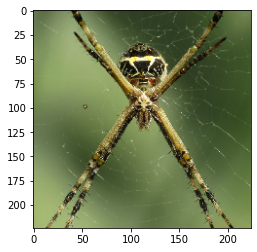

In [13]:
# Picking Random image from test data
image, label = cnn.test_generator.next()
test_img = image[random.randint(0,len(image)-1)]
plt.imshow(test_img);
test_img = np.expand_dims(test_img, axis=0)

#defining custom gradient
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad


dim1,dim2,dim3, gradients = [], [], [], []
for _ in range(10):
    d1 = np.random.randint(model.layers[9].output.shape[1])
    d2 = np.random.randint(model.layers[9].output.shape[2])
    d3 = np.random.randint(model.layers[9].output.shape[3])

    guided_single_model = Model(inputs=model.input, outputs=model.layers[9].output[:,d1,d2,d3])
    
    layer_dict = [layer for layer in guided_single_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        layer.activation = guidedRelu
    
    with tf.GradientTape() as tape:
        inputs = tf.cast(test_img, tf.float32)
        tape.watch(inputs)
        outputs = guided_single_model(inputs)
        
    gradients.append(tape.gradient(outputs,inputs))
    dim1.append(d1)
    dim2.append(d2)
    dim3.append(d3)


guided_image = []
indices = []
for j in range(10):
    grads = gradients[j][0].numpy()
    grads -= np.min(grads)
    if grads.max() - grads.min():
      grads /= grads.max() - grads.min()
    guided_image.append(np.clip(grads, 0, 1))
    indices.append("Neuron Index "+"("+str(dim1[j]) + "," + str(dim2[j]) + "," + str(dim3[j])+")")

In [ ]:
plt.figure(figsize=(30,40))
for j in range(10):
    ax = plt.subplot(2,5,j+1)
    plt.imshow(guided_image[j])
    plt.axis("off") 

In [14]:
wandb.log({"Question 5": [wandb.Image(img, caption=lbl) for img,lbl in zip(guided_image,indices)]}) 